In [1]:
!pip install kaggle

  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=8111932931c6aacb903e16e6a99f1beaf5dfccbc2d66c2684f5e21f97563cf8a
  Stored in directory: c:\users\kk\appdata\local\pip\cache\wheels\29\da\11\144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle


In [3]:
!kaggle competitions download -c titanic


  0%|          | 0.00/34.1k [00:00<?, ?B/s]
100%|##########| 34.1k/34.1k [00:00<00:00, 2.69MB/s]


In [1]:
import zipfile
with zipfile.ZipFile('./titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, losses
from keras.layers import Dense, Dropout, Input

In [286]:
train_df = pd.read_csv('train.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [287]:
test_X = pd.read_csv('test.csv')
test_X.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [288]:
submission_df = pd.read_csv('gender_submission.csv')
submission_df.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Preprocessing

In [289]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [203]:
for column in train_df.columns:
    print(column,len(train_df[column].unique()))

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 89
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 148
Embarked 4


In [296]:
train_df['Fare'].value_counts()[0]

15

In [169]:
train_X = train_df.drop('Survived', axis=1)
train_Y = train_df['Survived']

In [206]:
train_size = len(train_X)

In [210]:
merged_df = pd.concat([train_X, test_df])
merged_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [211]:
def preprocessing_df(df):
    df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    df['Cabin'].fillna('N/A', inplace=True)

    df['Age'].fillna(df['Age'].mean(), inplace=True)
    
    return df
    

In [212]:
merged_df = preprocessing_df(merged_df)

In [213]:
merged_df.info()
merged_df.head(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   object 
 2   Age       1309 non-null   float64
 3   SibSp     1309 non-null   int64  
 4   Parch     1309 non-null   int64  
 5   Fare      1308 non-null   float64
 6   Cabin     1309 non-null   object 
 7   Embarked  1309 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ KB


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,N/A,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,N/A,S
3,1,female,35.0,1,0,53.1000,C123,S


In [214]:
def EDA(df):
    df['Cabin'] = df['Cabin'].apply(lambda cabin : 'cabin' if cabin=='N/A' else 'not cabin')
    df['Family'] = df.apply(lambda row : 'single' if row['SibSp'] + row['Parch'] == 0 
                            else ('medium' if row['SibSp'] + row['Parch'] < 4 else 'large'), axis=1)
    def trans_age(x):
        if(x<1): x = int(str(x).split('.')[1])
        if(x<20): return 'young'
        if(x<60): return 'adult'
        return 'old'

    df['Age'] = df['Age'].apply(trans_age)
    df['Fare'] = df['Fare'].apply(lambda x : 'low' if x<df['Fare'].quantile(0.25) else('medium' if x<df['Fare'].quantile(0.5) 
                                                                                   else ('high' if x<df['Fare'].quantile(0.75) 
                                                                                         else 'very high')))
    
    df = df.drop(['SibSp', 'Parch'], axis=1)
    
    return df

In [216]:
merged_df = EDA(merged_df)

In [217]:
merged_df

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,3,male,adult,low,cabin,S,medium
1,1,female,adult,very high,not cabin,C,medium
2,3,female,adult,medium,cabin,S,single
3,1,female,adult,very high,not cabin,S,medium
4,3,male,adult,medium,cabin,S,single
...,...,...,...,...,...,...,...
413,3,male,adult,medium,cabin,S,single
414,1,female,adult,very high,not cabin,C,single
415,3,male,adult,low,cabin,S,single
416,3,male,adult,medium,cabin,S,single


In [220]:
merged_df = pd.get_dummies(merged_df)
merged_df

,Pclass,Sex_female,Sex_male,Age_adult,Age_old,Age_young,Fare_high,Fare_low,Fare_medium,Fare_very high,Cabin_cabin,Cabin_not cabin,Embarked_C,Embarked_Q,Embarked_S,Family_large,Family_medium,Family_single
0,3,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
1,1,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0
2,3,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1
3,1,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0
4,3,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1
414,1,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1
415,3,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1
416,3,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1


In [221]:
scaler = StandardScaler()
merged_df = scaler.fit_transform(merged_df)

In [222]:
train_X = merged_df[:train_size]
test_X = merged_df[train_size:]

In [223]:
features = train_X.shape[1]

In [265]:
def get_model():
    inputs = Input(shape=(features))
    
    x = Dense(256, activation='relu', kernel_initializer = "he_normal")(inputs)
    x = Dense(128, activation='relu', kernel_initializer = "he_normal")(x)
    x = Dense(64, activation='relu', kernel_initializer = "he_normal")(x)
    outputs= Dense(1, activation='sigmoid', kernel_initializer = "he_normal")(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)

In [266]:
model = get_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_32 (Dense)            (None, 256)               4864      
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 46,081
Trainable params: 46,081
Non-trainable params: 0
_________________________________________________________________


In [267]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [268]:
epochs = 1000
batch_size = 20
validation_split = 0.3

In [285]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_Y, test_size=0.3, random_state=42)

In [269]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test,y_test))

Epoch 1/1000
32/32 [==============================] - 1s 9ms/step - loss: 0.5580 - accuracy: 0.7657 - val_loss: 0.4434 - val_accuracy: 0.8022
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.8299 - val_loss: 0.4174 - val_accuracy: 0.8246
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4083 - accuracy: 0.8363 - val_loss: 0.4307 - val_accuracy: 0.7985
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4097 - accuracy: 0.8315 - val_loss: 0.4229 - val_accuracy: 0.8209
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3918 - accuracy: 0.8459 - val_loss: 0.4360 - val_accuracy: 0.8097
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.8363 - val_loss: 0.4336 - val_accuracy: 0.8134
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3844 - accuracy: 0.8363 - val_loss: 0.4394 - val_accuracy: 0.8209
Epoch 

32/32 [==============================] - 0s 2ms/step - loss: 0.3375 - accuracy: 0.8604 - val_loss: 0.4989 - val_accuracy: 0.8172
Epoch 59/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3340 - accuracy: 0.8571 - val_loss: 0.4974 - val_accuracy: 0.8246
Epoch 60/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8587 - val_loss: 0.4881 - val_accuracy: 0.8246
Epoch 61/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3431 - accuracy: 0.8571 - val_loss: 0.5031 - val_accuracy: 0.8172
Epoch 62/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3359 - accuracy: 0.8587 - val_loss: 0.4979 - val_accuracy: 0.8209
Epoch 63/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3339 - accuracy: 0.8539 - val_loss: 0.4963 - val_accuracy: 0.8209
Epoch 64/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3321 - accuracy: 0.8523 - val_loss: 0.4990 - val_accuracy: 0.8172
Epoch 65/1000

32/32 [==============================] - 0s 2ms/step - loss: 0.3197 - accuracy: 0.8539 - val_loss: 0.5727 - val_accuracy: 0.8209
Epoch 116/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8571 - val_loss: 0.5687 - val_accuracy: 0.8246
Epoch 117/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3207 - accuracy: 0.8604 - val_loss: 0.5561 - val_accuracy: 0.8246
Epoch 118/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3271 - accuracy: 0.8587 - val_loss: 0.5568 - val_accuracy: 0.8209
Epoch 119/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3245 - accuracy: 0.8555 - val_loss: 0.5590 - val_accuracy: 0.8284
Epoch 120/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3259 - accuracy: 0.8523 - val_loss: 0.5497 - val_accuracy: 0.8246
Epoch 121/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3202 - accuracy: 0.8571 - val_loss: 0.5627 - val_accuracy: 0.8246
Epoch 1

Epoch 172/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3150 - accuracy: 0.8636 - val_loss: 0.6740 - val_accuracy: 0.8284
Epoch 173/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3147 - accuracy: 0.8652 - val_loss: 0.6823 - val_accuracy: 0.8284
Epoch 174/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3142 - accuracy: 0.8636 - val_loss: 0.6953 - val_accuracy: 0.8284
Epoch 175/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3210 - accuracy: 0.8604 - val_loss: 0.6668 - val_accuracy: 0.8284
Epoch 176/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3184 - accuracy: 0.8620 - val_loss: 0.6504 - val_accuracy: 0.8284
Epoch 177/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3192 - accuracy: 0.8636 - val_loss: 0.6587 - val_accuracy: 0.8284
Epoch 178/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3167 - accuracy: 0.8636 - val_loss: 0.6493 - val_accuracy:

Epoch 229/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3122 - accuracy: 0.8636 - val_loss: 0.7059 - val_accuracy: 0.8246
Epoch 230/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3127 - accuracy: 0.8587 - val_loss: 0.7096 - val_accuracy: 0.8246
Epoch 231/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.8620 - val_loss: 0.7082 - val_accuracy: 0.8246
Epoch 232/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.8604 - val_loss: 0.6923 - val_accuracy: 0.8284
Epoch 233/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.8587 - val_loss: 0.6841 - val_accuracy: 0.8209
Epoch 234/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3137 - accuracy: 0.8636 - val_loss: 0.7081 - val_accuracy: 0.8284
Epoch 235/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.8652 - val_loss: 0.7109 - val_accuracy:

Epoch 286/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3110 - accuracy: 0.8652 - val_loss: 0.7730 - val_accuracy: 0.8246
Epoch 287/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3116 - accuracy: 0.8668 - val_loss: 0.7638 - val_accuracy: 0.8246
Epoch 288/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3147 - accuracy: 0.8636 - val_loss: 0.7585 - val_accuracy: 0.8246
Epoch 289/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3122 - accuracy: 0.8587 - val_loss: 0.7661 - val_accuracy: 0.8284
Epoch 290/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3118 - accuracy: 0.8668 - val_loss: 0.7609 - val_accuracy: 0.8246
Epoch 291/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3119 - accuracy: 0.8652 - val_loss: 0.7390 - val_accuracy: 0.8246
Epoch 292/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3114 - accuracy: 0.8668 - val_loss: 0.7541 - val_accuracy:

Epoch 343/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3125 - accuracy: 0.8636 - val_loss: 0.8585 - val_accuracy: 0.8284
Epoch 344/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3122 - accuracy: 0.8636 - val_loss: 0.8619 - val_accuracy: 0.8284
Epoch 345/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3116 - accuracy: 0.8620 - val_loss: 0.8562 - val_accuracy: 0.8284
Epoch 346/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.8620 - val_loss: 0.8551 - val_accuracy: 0.8284
Epoch 347/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3106 - accuracy: 0.8668 - val_loss: 0.8480 - val_accuracy: 0.8321
Epoch 348/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.8652 - val_loss: 0.8587 - val_accuracy: 0.8321
Epoch 349/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3098 - accuracy: 0.8636 - val_loss: 0.8654 - val_accuracy:

Epoch 400/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3108 - accuracy: 0.8604 - val_loss: 0.9086 - val_accuracy: 0.8284
Epoch 401/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3126 - accuracy: 0.8668 - val_loss: 0.8871 - val_accuracy: 0.8284
Epoch 402/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3177 - accuracy: 0.8668 - val_loss: 0.8609 - val_accuracy: 0.8246
Epoch 403/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.8652 - val_loss: 0.8688 - val_accuracy: 0.8284
Epoch 404/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3114 - accuracy: 0.8668 - val_loss: 0.9103 - val_accuracy: 0.8321
Epoch 405/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3114 - accuracy: 0.8636 - val_loss: 0.8568 - val_accuracy: 0.8284
Epoch 406/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3100 - accuracy: 0.8636 - val_loss: 0.8962 - val_accuracy:

Epoch 457/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3096 - accuracy: 0.8636 - val_loss: 0.8940 - val_accuracy: 0.8284
Epoch 458/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3093 - accuracy: 0.8668 - val_loss: 0.8759 - val_accuracy: 0.8246
Epoch 459/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.8636 - val_loss: 0.8801 - val_accuracy: 0.8246
Epoch 460/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3105 - accuracy: 0.8652 - val_loss: 0.8850 - val_accuracy: 0.8246
Epoch 461/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8636 - val_loss: 0.8881 - val_accuracy: 0.8284
Epoch 462/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.8604 - val_loss: 0.8914 - val_accuracy: 0.8246
Epoch 463/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8668 - val_loss: 0.8974 - val_accuracy:

Epoch 514/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3085 - accuracy: 0.8636 - val_loss: 0.8981 - val_accuracy: 0.8321
Epoch 515/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3082 - accuracy: 0.8652 - val_loss: 0.9058 - val_accuracy: 0.8321
Epoch 516/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8668 - val_loss: 0.9136 - val_accuracy: 0.8321
Epoch 517/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3094 - accuracy: 0.8652 - val_loss: 0.8930 - val_accuracy: 0.8321
Epoch 518/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3089 - accuracy: 0.8652 - val_loss: 0.8981 - val_accuracy: 0.8321
Epoch 519/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3105 - accuracy: 0.8652 - val_loss: 0.8968 - val_accuracy: 0.8321
Epoch 520/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.8636 - val_loss: 0.9073 - val_accuracy:

Epoch 571/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3097 - accuracy: 0.8652 - val_loss: 0.9111 - val_accuracy: 0.8321
Epoch 572/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3094 - accuracy: 0.8652 - val_loss: 0.8912 - val_accuracy: 0.8284
Epoch 573/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3110 - accuracy: 0.8668 - val_loss: 0.9218 - val_accuracy: 0.8284
Epoch 574/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.8636 - val_loss: 0.9299 - val_accuracy: 0.8284
Epoch 575/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3108 - accuracy: 0.8604 - val_loss: 0.8558 - val_accuracy: 0.8284
Epoch 576/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3093 - accuracy: 0.8668 - val_loss: 0.8567 - val_accuracy: 0.8321
Epoch 577/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3096 - accuracy: 0.8668 - val_loss: 0.8714 - val_accuracy:

Epoch 628/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8620 - val_loss: 1.0360 - val_accuracy: 0.8246
Epoch 629/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8668 - val_loss: 1.0204 - val_accuracy: 0.8284
Epoch 630/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3079 - accuracy: 0.8668 - val_loss: 1.0227 - val_accuracy: 0.8284
Epoch 631/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3082 - accuracy: 0.8668 - val_loss: 1.0150 - val_accuracy: 0.8284
Epoch 632/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3100 - accuracy: 0.8636 - val_loss: 1.0149 - val_accuracy: 0.8284
Epoch 633/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3094 - accuracy: 0.8652 - val_loss: 1.0204 - val_accuracy: 0.8246
Epoch 634/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3082 - accuracy: 0.8636 - val_loss: 1.0197 - val_accuracy:

Epoch 685/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8652 - val_loss: 1.0206 - val_accuracy: 0.8321
Epoch 686/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8652 - val_loss: 1.0299 - val_accuracy: 0.8321
Epoch 687/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8668 - val_loss: 1.0414 - val_accuracy: 0.8321
Epoch 688/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3077 - accuracy: 0.8652 - val_loss: 1.0477 - val_accuracy: 0.8321
Epoch 689/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3072 - accuracy: 0.8668 - val_loss: 1.0517 - val_accuracy: 0.8321
Epoch 690/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.8668 - val_loss: 1.0601 - val_accuracy: 0.8321
Epoch 691/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.8668 - val_loss: 1.0688 - val_accuracy:

Epoch 742/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8668 - val_loss: 1.0870 - val_accuracy: 0.8321
Epoch 743/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8652 - val_loss: 1.0932 - val_accuracy: 0.8321
Epoch 744/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.8668 - val_loss: 1.0832 - val_accuracy: 0.8321
Epoch 745/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8668 - val_loss: 1.0917 - val_accuracy: 0.8321
Epoch 746/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3077 - accuracy: 0.8652 - val_loss: 1.1003 - val_accuracy: 0.8321
Epoch 747/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3074 - accuracy: 0.8668 - val_loss: 1.0951 - val_accuracy: 0.8321
Epoch 748/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.8668 - val_loss: 1.1098 - val_accuracy:

Epoch 799/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8636 - val_loss: 1.0708 - val_accuracy: 0.8284
Epoch 800/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3094 - accuracy: 0.8668 - val_loss: 1.0690 - val_accuracy: 0.8284
Epoch 801/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3075 - accuracy: 0.8652 - val_loss: 1.0762 - val_accuracy: 0.8321
Epoch 802/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3079 - accuracy: 0.8652 - val_loss: 1.0750 - val_accuracy: 0.8246
Epoch 803/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8636 - val_loss: 1.0788 - val_accuracy: 0.8284
Epoch 804/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8652 - val_loss: 1.0928 - val_accuracy: 0.8246
Epoch 805/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3096 - accuracy: 0.8668 - val_loss: 1.1084 - val_accuracy:

Epoch 856/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.8652 - val_loss: 1.1090 - val_accuracy: 0.8246
Epoch 857/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3084 - accuracy: 0.8668 - val_loss: 1.1161 - val_accuracy: 0.8246
Epoch 858/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3077 - accuracy: 0.8620 - val_loss: 1.1206 - val_accuracy: 0.8246
Epoch 859/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3074 - accuracy: 0.8668 - val_loss: 1.1460 - val_accuracy: 0.8284
Epoch 860/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3150 - accuracy: 0.8668 - val_loss: 1.1170 - val_accuracy: 0.8284
Epoch 861/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3072 - accuracy: 0.8668 - val_loss: 1.0945 - val_accuracy: 0.8284
Epoch 862/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3074 - accuracy: 0.8636 - val_loss: 1.0972 - val_accuracy:

Epoch 913/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3228 - accuracy: 0.8636 - val_loss: 1.3586 - val_accuracy: 0.8246
Epoch 914/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3122 - accuracy: 0.8668 - val_loss: 1.2617 - val_accuracy: 0.8284
Epoch 915/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3107 - accuracy: 0.8652 - val_loss: 1.2867 - val_accuracy: 0.8284
Epoch 916/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3097 - accuracy: 0.8668 - val_loss: 1.2898 - val_accuracy: 0.8284
Epoch 917/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3108 - accuracy: 0.8668 - val_loss: 1.3050 - val_accuracy: 0.8284
Epoch 918/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3100 - accuracy: 0.8668 - val_loss: 1.3115 - val_accuracy: 0.8284
Epoch 919/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3075 - accuracy: 0.8668 - val_loss: 1.3154 - val_accuracy:

Epoch 970/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3069 - accuracy: 0.8620 - val_loss: 1.4220 - val_accuracy: 0.8284
Epoch 971/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.8652 - val_loss: 1.4397 - val_accuracy: 0.8284
Epoch 972/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.8668 - val_loss: 1.4279 - val_accuracy: 0.8284
Epoch 973/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3082 - accuracy: 0.8652 - val_loss: 1.4318 - val_accuracy: 0.8284
Epoch 974/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8652 - val_loss: 1.4330 - val_accuracy: 0.8284
Epoch 975/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3075 - accuracy: 0.8668 - val_loss: 1.4355 - val_accuracy: 0.8284
Epoch 976/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.8668 - val_loss: 1.4336 - val_accuracy:

In [270]:
def get_answer(pred):
    return np.where(pred>0.5, 1, 0).squeeze()

pred_train = model.predict(X_test)
answer_train = get_answer(pred_train)

def compare_test(answer, y):
    compare = (answer==y)
    print(compare.value_counts()[True] / len(compare))
compare_test(answer_train,y_test)

0.8552188552188552


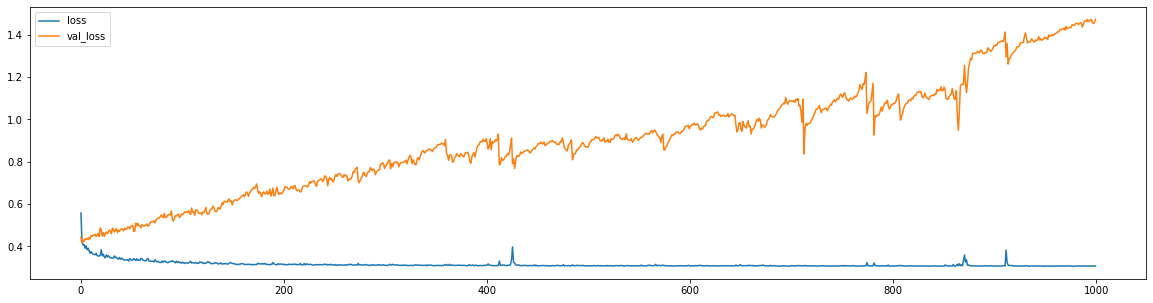

In [271]:
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [238]:
def submission_output(answer):
    submission_df['Survived'] = answer
    submission_df.to_csv('submission.csv', index=False)
    !kaggle competitions submit -c titanic -f submission.csv -m ""

In [231]:
test_pred = model.predict(test_X)
answer_test = get_answer(test_pred)
submission_output(answer_test)

In [275]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [276]:
answer_train=lr.predict(X_test)
compare_test(answer_train,y_test)

0.7985074626865671


In [237]:
answer_test = lr.predict(test_X)
submission_output(answer_test)

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.6kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 931B/s]  


In [277]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [278]:
answer_train=dtc.predict(X_test)
compare_test(answer_train,y_test)

0.7761194029850746


In [241]:
answer_test = dtc.predict(test_X)
submission_output(answer_test)

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 20.2kB/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.34kB/s]


In [297]:
rd_clf = RandomForestClassifier(n_estimators=100, max_depth=5)
rd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [298]:
answer_train=rd_clf.predict(X_test)
compare_test(answer_train,y_test)

0.7947761194029851


In [244]:
answer_test = rd_clf.predict(test_X)
submission_output(answer_test)

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.7kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 936B/s]  


In [281]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [282]:
answer_train=gb.predict(X_test)
compare_test(answer_train,y_test)

0.7835820895522388


In [255]:
answer_test = gb.predict(test_X)
submission_output(answer_test)

400 - Bad Request



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 21.3kB/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.11kB/s]


In [283]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [284]:
answer_train=xgb.predict(X_test)
compare_test(answer_train,y_test)

0.7947761194029851


In [252]:
answer_test = xgb.predict(test_X)
submission_output(answer_test)

400 - Bad Request



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.4kB/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.09kB/s]
